<a href="https://colab.research.google.com/github/sjnaj/DeepLearning/blob/master/Basic/%E6%88%BF%E4%BB%B7%E9%A2%84%E6%B5%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 实战Kaggle比赛：预测房价

## 数据集下载

首先，我们建立字典DATA_HUB， 它可以将数据集名称的字符串映射到数据集相关的二元组上， 这个二元组包含数据集的url和验证文件完整性的sha-1密钥。 所有类似的数据集都托管在地址为DATA_URL的站点上。

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
def download(name,cache_dir=os.path.join("..",'data')):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url,sha1_hash=DATA_HUB[name]
    os.makedirs(cache_dir,exist_ok=True)#创建文件夹，即使存在也不报错
    fname=os.path.join(cache_dir,url.split('/')[-1])#把url的最后一段作为文件名，放在../data里
    if os.path.exists(fname):
      sha1=hashlib.sha1()#创建sha1对象 Secure Hash Algorithm", 是“安全散列算法”的意思。
      with open(fname,'rb') as f:
        while True:
          data=f.read(1048576)
          if not data:
            break
          sha1.update(data)#传入数据并加密
          if sha1.hexdigest()==sha1_hash:#hash摘要相等：（十六进制数据字符串值）
            return fname   # 命中缓存，没命中则下载或更新
    print(f'正在从{url}下载{fname}...')
    r=requests.get(url,stream=True,verify=True)#验证网站数字证书
    with open(fname,'wb') as f:
      f.write(r.content)
    return fname



In [3]:
def download_extract(name,folder=None):
  '''下载并解压zip/tar文件'''
  fname=download(name)
  base_dir=os.path.dirname(fname)
  data_dir,ext=os.path.splitext(fname)#Extension is everything from the last dot to the end, ignoring leading dots.  Returns "(root, ext)"; ext may be empty
  if ext=='.zip':
    fp=zipfile.ZipFile(fname,'r')
  elif ext in ('.tar','.gz'):
    fp=tarfile.open(fname,'r')
  else:
    assert False,'只有zip/tar/gz文件可以被解压缩'
  fp.extractall(base_dir)#解压在base_dir
  return os.path.join(base_dir,folder) if folder else data_dir

def download_all():
  '''下载DATA_HUB中的所有文件'''
  for name in DATA_HUB:
    download(name)

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


In [5]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [7]:
train_data=pd.read_csv(download('kaggle_house_train'))
test_data=pd.read_csv(download('kaggle_house_test'))

训练数据集包括1460个样本，每个样本80个特征和1个标签， 而测试数据集包含1459个样本，每个样本80个特征。

In [8]:
print(train_data.shape)
print(test_data.shape)

print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])#观察前四行的部分特征


(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


在每个样本中，第一个特征是ID， 这有助于模型识别每个训练样本。 虽然这很方便，但它不携带任何用于预测的信息。 因此，在将数据提供给模型之前，我们将其从数据集中删除。

In [9]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))#注意还要去除train的label，连接起来成为features



为了将所有特征放在一个共同的尺度上， 我们通过将特征重新缩放到零均值和单位方差来标准化数据

$x \leftarrow \frac{x - \mu}{\sigma}$

直观地说，我们标准化数据有两个原因： 首先，它方便优化。 其次，因为我们不知道哪些特征是相关的， 所以我们不想让惩罚分配给一个特征的系数比分配给其他任何特征的系数更大。

In [10]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index#获取布尔矩阵，以防止对object类型的数据进行处理，例如string
all_features[numeric_features] = all_features[numeric_features].apply(#标准化
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)#将nan填充为0

接下来，我们处理离散值。 这包括诸如“MSZoning”之类的特征。 我们用独热编码替换它们， 方法与前面将多类别标签转换为向量的方式相同 。 例如，“MSZoning”包含值“RL”和“Rm”。 我们将创建两个新的指示器特征“MSZoning_RL”和“MSZoning_RM”，其值为0或1。 根据独热编码，如果“MSZoning”的原始值为“RL”， 则：“MSZoning_RL”为1，“MSZoning_RM”为0。

In [11]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features=pd.get_dummies(all_features,dummy_na=True)

all_features.shape

(2919, 331)

此转换会将特征的总数量从79个增加到331个

最后，通过values属性，我们可以 从pandas格式中提取NumPy格式，并将其转换为张量表示用于训练。

In [12]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)
#注意dtype

In [13]:
loss=nn.MSELoss()
in_features=train_features.shape[1]#输入向量维度

def get_net():
  net=nn.Sequential(nn.Linear(in_features,1))
  return net



房价就像股票价格一样，我们关心的是相对数量，而不是绝对数量

解决这个问题的一种方法是用价格预测的对数来衡量差异。 事实上，这也是比赛中官方用来评价提交质量的误差指标。

 即将$\delta$ for $|\log y - \log \hat{y}| \leq \delta$
 转换为$e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$
 
这使得预测价格的对数与真实标签价格的对数之间出现以下均方根误差：

$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$

In [14]:
def log_rmse(net,features,labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
  clipped_preds=torch.clamp(net(features),1,float('inf'))#将输入input张量每个元素的范围限制到区间 [min,max]，返回结果到一个新张量。
  rmse=torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
  return rmse.item()#返回里面的标量

def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
  train_ls,test_ls=[],[]
  train_iter = d2l.load_array((train_features, train_labels), batch_size)
  # 这里使用的是Adam优化算法,对lr不那么敏感
  optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate,weight_decay = weight_decay)
  for epoch in range(num_epochs):
    for X,y in train_iter:
      optimizer.zero_grad()
      l=loss(net(X),y)
      l.backward()
      optimizer.step()
    train_ls.append(log_rmse(net, train_features, train_labels))
    if test_labels is not None:
      test_ls.append(log_rmse(net, test_features, test_labels))
  return train_ls, test_ls


K折交叉验证

In [15]:
def get_k_fold_data(k,i,X,y):
  assert k>1
  fold_size=X.shape[0]//k#计算折数
  X_train,y_train=None,None
  for j in range(k):
    idx=slice(j*fold_size,(j+1)*fold_size)#创建一个slice对象，简洁代码
    X_part,y_part=X[idx,:],y[idx]
    if j==i:#一折作为验证集
      X_valid,y_valid=X_part,y_part
    # 其余作为训练集
    elif X_train is None:#这一步可通过初始为空tensor替代
      X_train,y_train=X_part,y_part
    else:
      X_train=torch.cat([X_train,X_part],0)#按第0维拼接tensor
      y_train=torch.cat([y_train,y_part],0)
  return X_train,y_train,X_valid,y_valid

In [16]:
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_dacay,batch_size):
  train_l_sum,valid_l_sum=0,0#损失和
  for i in range(k):
    data=get_k_fold_data(k,i,X_train,y_train)
    net=get_net()
    train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
    #取最后一个epoch的损失作为每一折的损失
    train_l_sum+=train_ls[-1]
    valid_l_sum+=valid_ls[-1]
    if i==0:#只打印第0折的数据
      d2l.plot(list(range(1,num_epochs+1)),[train_ls,valid_ls],xlabel='epoch',ylabel='rmse',xlim=[1,num_epochs],legend=['train','valid'],yscale='log')
    print(f'折{i+1},训练log rmse{float(train_ls[-1]):f}')
    print(f'验证log rmse{float(valid_ls[-1]):f}')
  return train_l_sum/k,valid_l_sum/k#返回每折的平均损失


折1,训练log rmse0.171182
验证log rmse0.157118
折2,训练log rmse0.162595
验证log rmse0.190245
折3,训练log rmse0.164080
验证log rmse0.168504
折4,训练log rmse0.168763
验证log rmse0.154905
折5,训练log rmse0.162861
验证log rmse0.182948
5-折验证: 平均训练log rmse: 0.165896, 平均验证log rmse: 0.170744


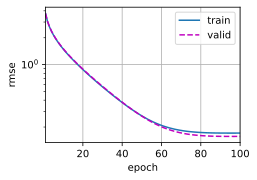

In [17]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
def get_net():
  net=nn.Sequential(nn.Linear(in_features,1))
  return net
import traceback


try:
  train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
  print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')
except:
  traceback.print_exc()


折1,训练log rmse0.002290
验证log rmse0.002131
折2,训练log rmse0.003215
验证log rmse0.002978
折3,训练log rmse0.002122
验证log rmse0.021891
折4,训练log rmse0.002030
验证log rmse0.004838
折5,训练log rmse0.002252
验证log rmse0.021882
5-折验证: 平均训练log rmse: 0.002382, 平均验证log rmse: 0.010744


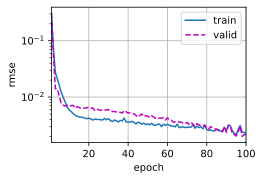

In [64]:
num_hidden1=in_features
num_hidden2=num_hidden1


def init_weights(m):
  if type(m)==nn.Linear:
    nn.init.xavier_normal_(m.weight)
def get_net():
  net=nn.Sequential(nn.Linear(in_features,num_hidden1),
        nn.RReLU(),#也很有用
        nn.Linear(num_hidden2,1)
  )
  net.apply(init_weights)
  return net

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.4, 3, 64

import random
random.seed(47)
#打乱（很有用）
randomize = torch.arange(len(train_features))
random.shuffle(randomize)
train_features = train_features[randomize]
train_labels = train_labels[randomize]
try:
    train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
    print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')
except:
    traceback.print_exc()


折1,训练log rmse0.002679
验证log rmse0.005049
折2,训练log rmse0.002261
验证log rmse0.002226
折3,训练log rmse0.003006
验证log rmse0.002908
折4,训练log rmse0.002543
验证log rmse0.002450
折5,训练log rmse0.003022
验证log rmse0.011721
5-折验证: 平均训练log rmse: 0.002702, 平均验证log rmse: 0.004871


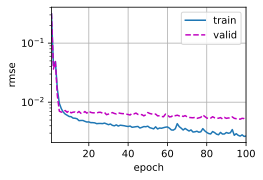

In [65]:
num_hidden1=in_features
num_hidden2=num_hidden1


def init_weights(m):
  if type(m)==nn.Linear:
    nn.init.xavier_normal_(m.weight)
def get_net():
  net=nn.Sequential(nn.Linear(in_features,num_hidden1),
        nn.RReLU(),#也很有用
        nn.Linear(num_hidden2,1)
  )
  net.apply(init_weights)
  return net

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.35, 3, 64

import random
random.seed(47)
#打乱（很有用）
randomize = torch.arange(len(train_features))
random.shuffle(randomize)
train_features = train_features[randomize]
train_labels = train_labels[randomize]
try:
    train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
    print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')
except:
    traceback.print_exc()


折1,训练log rmse0.002921
验证log rmse0.002597
折2,训练log rmse0.002075
验证log rmse0.002042
折3,训练log rmse0.002586
验证log rmse0.002588
折4,训练log rmse0.002430
验证log rmse0.002291
折5,训练log rmse0.003992
验证log rmse0.014061
5-折验证: 平均训练log rmse: 0.002801, 平均验证log rmse: 0.004716


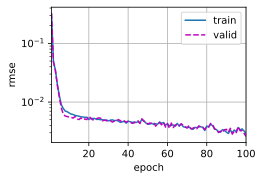

In [67]:
num_hidden1=in_features
num_hidden2=num_hidden1


def init_weights(m):
  if type(m)==nn.Linear:
    nn.init.xavier_normal_(m.weight)
def get_net():
  net=nn.Sequential(nn.Linear(in_features,num_hidden1),
        nn.RReLU(),#也很有用
        nn.Linear(num_hidden2,1)
  )
  net.apply(init_weights)
  return net

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.4, 3, 64

import random
random.seed(47)
#打乱（很有用）
randomize = np.arange(len(train_features))
random.shuffle(randomize)
train_features = train_features[randomize]
train_labels = train_labels[randomize]
try:
    train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
    print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')
except:
    traceback.print_exc()


折1,训练log rmse0.002460
验证log rmse0.002508
折2,训练log rmse0.002548
验证log rmse0.002669
折3,训练log rmse0.002617
验证log rmse0.002603
折4,训练log rmse0.002247
验证log rmse0.002179
折5,训练log rmse0.001895
验证log rmse0.001853
5-折验证: 平均训练log rmse: 0.002353, 平均验证log rmse: 0.002363


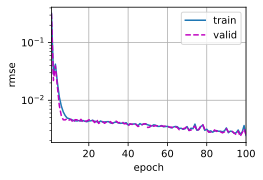

In [69]:
num_hidden1=in_features
num_hidden2=num_hidden1


def init_weights(m):
  if type(m)==nn.Linear:
    nn.init.xavier_normal_(m.weight)
def get_net():
  net=nn.Sequential(nn.Linear(in_features,num_hidden1),
        nn.RReLU(),#也很有用
        nn.Linear(num_hidden2,1)
  )
  net.apply(init_weights)
  return net

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.37, 3, 64

import random
random.seed(47)
#打乱（很有用）
randomize = torch.arange(len(train_features))
random.shuffle(randomize)
train_features = train_features[randomize]
train_labels = train_labels[randomize]
try:
    train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
    print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')
except:
    traceback.print_exc()


折1,训练log rmse0.002481
验证log rmse0.002356
折2,训练log rmse0.002356
验证log rmse0.002438
折3,训练log rmse0.002628
验证log rmse0.002870
折4,训练log rmse0.002357
验证log rmse0.002752
折5,训练log rmse0.002671
验证log rmse0.009757
5-折验证: 平均训练log rmse: 0.002498, 平均验证log rmse: 0.004035


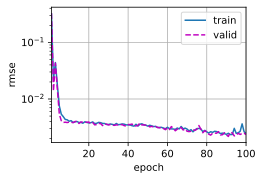

In [71]:
num_hidden1=in_features
num_hidden2=num_hidden1


def init_weights(m):
  if type(m)==nn.Linear:
    nn.init.xavier_normal_(m.weight)
def get_net():
  net=nn.Sequential(nn.Linear(in_features,num_hidden1),
        nn.RReLU(),#也很有用
        nn.Linear(num_hidden2,1)
  )
  net.apply(init_weights)
  return net

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.36, 3, 64

import random
random.seed(47)
#打乱（很有用）
randomize = torch.arange(len(train_features))
random.shuffle(randomize)
train_features = train_features[randomize]
train_labels = train_labels[randomize]
try:
    train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
    print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')
except:
    traceback.print_exc()


折1,训练log rmse0.002953
验证log rmse0.002935
折2,训练log rmse0.002189
验证log rmse0.002130
折3,训练log rmse0.002371
验证log rmse0.002407
折4,训练log rmse0.002071
验证log rmse0.014432
折5,训练log rmse0.002524
验证log rmse0.002411
5-折验证: 平均训练log rmse: 0.002422, 平均验证log rmse: 0.004863


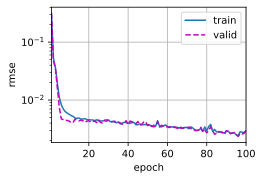

In [70]:
num_hidden1=in_features
num_hidden2=num_hidden1


def init_weights(m):
  if type(m)==nn.Linear:
    nn.init.xavier_normal_(m.weight)
def get_net():
  net=nn.Sequential(nn.Linear(in_features,num_hidden1),
        nn.RReLU(),#也很有用
        nn.Linear(num_hidden2,1)
  )
  net.apply(init_weights)
  return net

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.38, 3, 64

import random
random.seed(47)
#打乱（很有用）
randomize = torch.arange(len(train_features))
random.shuffle(randomize)
train_features = train_features[randomize]
train_labels = train_labels[randomize]
try:
    train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
    print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')
except:
    traceback.print_exc()


折1,训练log rmse0.001735
验证log rmse0.001751
折2,训练log rmse0.002603
验证log rmse0.002702
折3,训练log rmse0.002204
验证log rmse0.002090
折4,训练log rmse0.001862
验证log rmse0.001759
折5,训练log rmse0.001930
验证log rmse0.001786
5-折验证: 平均训练log rmse: 0.002067, 平均验证log rmse: 0.002018


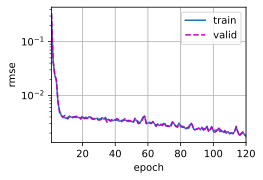

In [74]:
num_hidden1=in_features
num_hidden2=num_hidden1


def init_weights(m):
  if type(m)==nn.Linear:
    nn.init.xavier_normal_(m.weight)
def get_net():
  net=nn.Sequential(nn.Linear(in_features,num_hidden1),
        nn.RReLU(),#也很有用
        nn.Linear(num_hidden2,1)
  )
  net.apply(init_weights)
  return net

k, num_epochs, lr, weight_decay, batch_size = 5, 120, 0.37, 3, 64

import random
random.seed(47)
#打乱（很有用）
randomize = torch.arange(len(train_features))
random.shuffle(randomize)
train_features = train_features[randomize]
train_labels = train_labels[randomize]
try:
    train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
    print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')
except:
    traceback.print_exc()


折1,训练log rmse0.002021
验证log rmse0.001998
折2,训练log rmse0.001834
验证log rmse0.001789
折3,训练log rmse0.001909
验证log rmse0.001982
折4,训练log rmse0.001706
验证log rmse0.001660
折5,训练log rmse0.001699
验证log rmse0.001621
5-折验证: 平均训练log rmse: 0.001834, 平均验证log rmse: 0.001810


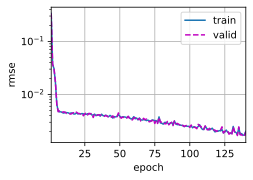

In [82]:
num_hidden1=in_features
num_hidden2=num_hidden1


def init_weights(m):
  if type(m)==nn.Linear:
    nn.init.xavier_normal_(m.weight)
def get_net():
  net=nn.Sequential(nn.Linear(in_features,num_hidden1),
        nn.RReLU(),#也很有用
        nn.Linear(num_hidden2,1)
  )
  net.apply(init_weights)
  return net

k, num_epochs, lr, weight_decay, batch_size = 5, 140, 0.37, 3, 64

import random
random.seed(47)
#打乱（很有用）
randomize = torch.arange(len(train_features))
random.shuffle(randomize)
train_features = train_features[randomize]
train_labels = train_labels[randomize]
try:
    train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
    print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')
except:
    traceback.print_exc()


训练log rmse：0.001342


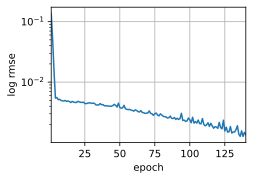

In [83]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)#用超参数在全集上训练一次
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

#在colab目录那里下载
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)